## import file

In [167]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [168]:
import pandas as pd
import numpy as np
train_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train_final.csv')
test_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test_final.csv')

# train_data.head()
test_data.head()

,continuous_annual_inc,continuous_annual_inc_joint,continuous_delinq_2yrs,continuous_dti,continuous_dti_joint,continuous_fico_range_high,continuous_fico_range_low,continuous_funded_amnt,continuous_funded_amnt_inv,continuous_inq_last_6mths,continuous_installment,continuous_int_rate,continuous_last_fico_range_high,continuous_last_fico_range_low,continuous_loan_amnt,loan_status,continuous_mths_since_last_delinq,continuous_mths_since_last_major_derog,continuous_mths_since_last_record,continuous_open_acc,continuous_pub_rec,discrete_addr_state_1_one_hot,discrete_addr_state_2_one_hot,discrete_addr_state_3_one_hot,discrete_addr_state_4_one_hot,discrete_addr_state_5_one_hot,discrete_addr_state_6_one_hot,discrete_addr_state_7_one_hot,discrete_addr_state_8_one_hot,discrete_addr_state_9_one_hot,discrete_addr_state_10_one_hot,discrete_addr_state_11_one_hot,discrete_addr_state_12_one_hot,discrete_addr_state_13_one_hot,discrete_addr_state_14_one_hot,discrete_addr_state_15_one_hot,discrete_addr_state_16_one_hot,discrete_addr_state_17_one_hot,discrete_addr_state_18_one_hot,discrete_addr_state_19_one_hot,...,discrete_purpose_11_one_hot,discrete_purpose_12_one_hot,discrete_pymnt_plan_1_one_hot,discrete_sub_grade_1_one_hot,discrete_sub_grade_2_one_hot,discrete_sub_grade_3_one_hot,discrete_sub_grade_4_one_hot,discrete_sub_grade_5_one_hot,discrete_sub_grade_6_one_hot,discrete_sub_grade_7_one_hot,discrete_sub_grade_8_one_hot,discrete_sub_grade_9_one_hot,discrete_sub_grade_10_one_hot,discrete_sub_grade_11_one_hot,discrete_sub_grade_12_one_hot,discrete_sub_grade_13_one_hot,discrete_sub_grade_14_one_hot,discrete_sub_grade_15_one_hot,discrete_sub_grade_16_one_hot,discrete_sub_grade_17_one_hot,discrete_sub_grade_18_one_hot,discrete_sub_grade_19_one_hot,discrete_sub_grade_20_one_hot,discrete_sub_grade_21_one_hot,discrete_sub_grade_22_one_hot,discrete_sub_grade_23_one_hot,discrete_sub_grade_24_one_hot,discrete_sub_grade_25_one_hot,discrete_sub_grade_26_one_hot,discrete_sub_grade_27_one_hot,discrete_sub_grade_28_one_hot,discrete_sub_grade_29_one_hot,discrete_sub_grade_30_one_hot,discrete_sub_grade_31_one_hot,discrete_sub_grade_32_one_hot,discrete_sub_grade_33_one_hot,discrete_sub_grade_34_one_hot,discrete_sub_grade_35_one_hot,discrete_term_1_one_hot,discrete_term_2_one_hot
0,35000.0,NaN,1.0,25.65,NaN,664.0,660.0,13000.0,13000.0,1.0,428.63,11.49,659.0,655.0,13000.0,1,3.0,3.0,NaN,12.0,0.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,50000.0,NaN,0.0,22.01,NaN,729.0,725.0,11000.0,11000.0,0.0,339.10,6.89,769.0,765.0,11000.0,1,NaN,NaN,NaN,25.0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
2,100000.0,NaN,0.0,26.39,NaN,764.0,760.0,10000.0,10000.0,1.0,301.15,5.32,684.0,680.0,10000.0,1,NaN,NaN,NaN,23.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,55000.0,NaN,0.0,12.26,NaN,664.0,660.0,13800.0,13800.0,0.0,318.75,13.67,724.0,720.0,13800.0,1,55.0,55.0,NaN,13.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,50000.0,NaN,0.0,17.55,NaN,674.0,670.0,13550.0,13550.0,3.0,491.23,18.20,574.0,570.0,13550.0,1,29.0,82.0,NaN,7.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0


In [169]:
x_train = train_data.drop(columns=['loan_status'])
x_test = test_data.drop(columns=['loan_status'])


y_train = train_data[['loan_status']]
y_test = test_data[['loan_status']]

x_test.head()

,continuous_annual_inc,continuous_annual_inc_joint,continuous_delinq_2yrs,continuous_dti,continuous_dti_joint,continuous_fico_range_high,continuous_fico_range_low,continuous_funded_amnt,continuous_funded_amnt_inv,continuous_inq_last_6mths,continuous_installment,continuous_int_rate,continuous_last_fico_range_high,continuous_last_fico_range_low,continuous_loan_amnt,continuous_mths_since_last_delinq,continuous_mths_since_last_major_derog,continuous_mths_since_last_record,continuous_open_acc,continuous_pub_rec,discrete_addr_state_1_one_hot,discrete_addr_state_2_one_hot,discrete_addr_state_3_one_hot,discrete_addr_state_4_one_hot,discrete_addr_state_5_one_hot,discrete_addr_state_6_one_hot,discrete_addr_state_7_one_hot,discrete_addr_state_8_one_hot,discrete_addr_state_9_one_hot,discrete_addr_state_10_one_hot,discrete_addr_state_11_one_hot,discrete_addr_state_12_one_hot,discrete_addr_state_13_one_hot,discrete_addr_state_14_one_hot,discrete_addr_state_15_one_hot,discrete_addr_state_16_one_hot,discrete_addr_state_17_one_hot,discrete_addr_state_18_one_hot,discrete_addr_state_19_one_hot,discrete_addr_state_20_one_hot,...,discrete_purpose_11_one_hot,discrete_purpose_12_one_hot,discrete_pymnt_plan_1_one_hot,discrete_sub_grade_1_one_hot,discrete_sub_grade_2_one_hot,discrete_sub_grade_3_one_hot,discrete_sub_grade_4_one_hot,discrete_sub_grade_5_one_hot,discrete_sub_grade_6_one_hot,discrete_sub_grade_7_one_hot,discrete_sub_grade_8_one_hot,discrete_sub_grade_9_one_hot,discrete_sub_grade_10_one_hot,discrete_sub_grade_11_one_hot,discrete_sub_grade_12_one_hot,discrete_sub_grade_13_one_hot,discrete_sub_grade_14_one_hot,discrete_sub_grade_15_one_hot,discrete_sub_grade_16_one_hot,discrete_sub_grade_17_one_hot,discrete_sub_grade_18_one_hot,discrete_sub_grade_19_one_hot,discrete_sub_grade_20_one_hot,discrete_sub_grade_21_one_hot,discrete_sub_grade_22_one_hot,discrete_sub_grade_23_one_hot,discrete_sub_grade_24_one_hot,discrete_sub_grade_25_one_hot,discrete_sub_grade_26_one_hot,discrete_sub_grade_27_one_hot,discrete_sub_grade_28_one_hot,discrete_sub_grade_29_one_hot,discrete_sub_grade_30_one_hot,discrete_sub_grade_31_one_hot,discrete_sub_grade_32_one_hot,discrete_sub_grade_33_one_hot,discrete_sub_grade_34_one_hot,discrete_sub_grade_35_one_hot,discrete_term_1_one_hot,discrete_term_2_one_hot
0,35000.0,NaN,1.0,25.65,NaN,664.0,660.0,13000.0,13000.0,1.0,428.63,11.49,659.0,655.0,13000.0,3.0,3.0,NaN,12.0,0.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,50000.0,NaN,0.0,22.01,NaN,729.0,725.0,11000.0,11000.0,0.0,339.10,6.89,769.0,765.0,11000.0,NaN,NaN,NaN,25.0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
2,100000.0,NaN,0.0,26.39,NaN,764.0,760.0,10000.0,10000.0,1.0,301.15,5.32,684.0,680.0,10000.0,NaN,NaN,NaN,23.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,55000.0,NaN,0.0,12.26,NaN,664.0,660.0,13800.0,13800.0,0.0,318.75,13.67,724.0,720.0,13800.0,55.0,55.0,NaN,13.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,50000.0,NaN,0.0,17.55,NaN,674.0,670.0,13550.0,13550.0,3.0,491.23,18.20,574.0,570.0,13550.0,29.0,82.0,NaN,7.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0


In [170]:
TRAIN_IDX=x_train.shape[0]
TEST_IDX = TRAIN_IDX + x_test.shape[0]
print(TRAIN_IDX, TEST_IDX)

50000 100000


In [171]:
x = pd.concat([x_train, x_test], axis=0)
y = pd.concat([y_train, y_test], axis=0)

# print(x.shape, y.shape)
# print(x, y)

data = pd.concat([x, y], axis=1)
print(data)

       continuous_annual_inc  ...  loan_status
0                    55000.0  ...            1
1                    65000.0  ...            1
2                    63000.0  ...            1
3                   104433.0  ...            1
4                    34000.0  ...            1
...                      ...  ...          ...
49995                46009.0  ...            1
49996                50000.0  ...            0
49997                90000.0  ...            1
49998                54000.0  ...            1
49999                76000.0  ...            1

[100000 rows x 146 columns]


In [172]:
data.columns.to_list()
# print(len(data.columns.to_list()))

['continuous_annual_inc',
 'continuous_annual_inc_joint',
 'continuous_delinq_2yrs',
 'continuous_dti',
 'continuous_dti_joint',
 'continuous_fico_range_high',
 'continuous_fico_range_low',
 'continuous_funded_amnt',
 'continuous_funded_amnt_inv',
 'continuous_inq_last_6mths',
 'continuous_installment',
 'continuous_int_rate',
 'continuous_last_fico_range_high',
 'continuous_last_fico_range_low',
 'continuous_loan_amnt',
 'continuous_mths_since_last_delinq',
 'continuous_mths_since_last_major_derog',
 'continuous_mths_since_last_record',
 'continuous_open_acc',
 'continuous_pub_rec',
 'discrete_addr_state_1_one_hot',
 'discrete_addr_state_2_one_hot',
 'discrete_addr_state_3_one_hot',
 'discrete_addr_state_4_one_hot',
 'discrete_addr_state_5_one_hot',
 'discrete_addr_state_6_one_hot',
 'discrete_addr_state_7_one_hot',
 'discrete_addr_state_8_one_hot',
 'discrete_addr_state_9_one_hot',
 'discrete_addr_state_10_one_hot',
 'discrete_addr_state_11_one_hot',
 'discrete_addr_state_12_one_hot'

In [173]:
data['loan_status'].unique()

array([1, 0])

In [174]:
data['loan_status'].value_counts()

1    80014
0    19986
Name: loan_status, dtype: int64

In [175]:
data.loc[0]

,continuous_annual_inc,continuous_annual_inc_joint,continuous_delinq_2yrs,continuous_dti,continuous_dti_joint,continuous_fico_range_high,continuous_fico_range_low,continuous_funded_amnt,continuous_funded_amnt_inv,continuous_inq_last_6mths,continuous_installment,continuous_int_rate,continuous_last_fico_range_high,continuous_last_fico_range_low,continuous_loan_amnt,continuous_mths_since_last_delinq,continuous_mths_since_last_major_derog,continuous_mths_since_last_record,continuous_open_acc,continuous_pub_rec,discrete_addr_state_1_one_hot,discrete_addr_state_2_one_hot,discrete_addr_state_3_one_hot,discrete_addr_state_4_one_hot,discrete_addr_state_5_one_hot,discrete_addr_state_6_one_hot,discrete_addr_state_7_one_hot,discrete_addr_state_8_one_hot,discrete_addr_state_9_one_hot,discrete_addr_state_10_one_hot,discrete_addr_state_11_one_hot,discrete_addr_state_12_one_hot,discrete_addr_state_13_one_hot,discrete_addr_state_14_one_hot,discrete_addr_state_15_one_hot,discrete_addr_state_16_one_hot,discrete_addr_state_17_one_hot,discrete_addr_state_18_one_hot,discrete_addr_state_19_one_hot,discrete_addr_state_20_one_hot,...,discrete_purpose_12_one_hot,discrete_pymnt_plan_1_one_hot,discrete_sub_grade_1_one_hot,discrete_sub_grade_2_one_hot,discrete_sub_grade_3_one_hot,discrete_sub_grade_4_one_hot,discrete_sub_grade_5_one_hot,discrete_sub_grade_6_one_hot,discrete_sub_grade_7_one_hot,discrete_sub_grade_8_one_hot,discrete_sub_grade_9_one_hot,discrete_sub_grade_10_one_hot,discrete_sub_grade_11_one_hot,discrete_sub_grade_12_one_hot,discrete_sub_grade_13_one_hot,discrete_sub_grade_14_one_hot,discrete_sub_grade_15_one_hot,discrete_sub_grade_16_one_hot,discrete_sub_grade_17_one_hot,discrete_sub_grade_18_one_hot,discrete_sub_grade_19_one_hot,discrete_sub_grade_20_one_hot,discrete_sub_grade_21_one_hot,discrete_sub_grade_22_one_hot,discrete_sub_grade_23_one_hot,discrete_sub_grade_24_one_hot,discrete_sub_grade_25_one_hot,discrete_sub_grade_26_one_hot,discrete_sub_grade_27_one_hot,discrete_sub_grade_28_one_hot,discrete_sub_grade_29_one_hot,discrete_sub_grade_30_one_hot,discrete_sub_grade_31_one_hot,discrete_sub_grade_32_one_hot,discrete_sub_grade_33_one_hot,discrete_sub_grade_34_one_hot,discrete_sub_grade_35_one_hot,discrete_term_1_one_hot,discrete_term_2_one_hot,loan_status
0,55000.0,NaN,0.0,5.91,NaN,679.0,675.0,3600.0,3600.0,1.0,123.03,13.99,564.0,560.0,3600.0,30.0,30.0,NaN,7.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
0,35000.0,NaN,1.0,25.65,NaN,664.0,660.0,13000.0,13000.0,1.0,428.63,11.49,659.0,655.0,13000.0,3.0,3.0,NaN,12.0,0.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1


## TreeBased Models  

In [176]:
train = data.iloc[:TRAIN_IDX, :]
test = data.iloc[TRAIN_IDX:TEST_IDX, :]
print(test)

       continuous_annual_inc  ...  loan_status
0                    35000.0  ...            1
1                    50000.0  ...            1
2                   100000.0  ...            1
3                    55000.0  ...            1
4                    50000.0  ...            1
...                      ...  ...          ...
49995                46009.0  ...            1
49996                50000.0  ...            0
49997                90000.0  ...            1
49998                54000.0  ...            1
49999                76000.0  ...            1

[50000 rows x 146 columns]


In [177]:
import lightgbm as lgb
train_dataset = lgb.Dataset(train.drop(columns='loan_status'), train['loan_status'])
test_dataset = lgb.Dataset(test.drop(columns='loan_status'), test['loan_status'])

In [178]:
# param = {'num_leaves': 31, 'objective': 'binary', 'metric':'binary_error'}
# num_round = 2000

In [179]:
# model = lgb.train(param, train_dataset, num_boost_round=num_round, valid_sets=[train_dataset, test_dataset])
# print(model)

In [180]:
# from sklearn.metrics import accuracy_score
# y_pred = (model.predict(test.drop(columns=['loan_status']), num_iteration=num_round) > 0.5).astype(int)
# print(test['loan_status'], y_pred)
# accuracy = accuracy_score(test['loan_status'], y_pred)
# print(accuracy)

In [181]:
import io
import multiprocessing
from contextlib import redirect_stdout
from copy import deepcopy
from dataclasses import dataclass, asdict
import hyperopt.pyll
from hyperopt import fmin, tpe, hp
import numpy as np
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
import torch

import copy
cpu_count = 4
use_gpu = False
@dataclass
class LGBOpt:
    num_threads: any = hp.choice('num_threads', [cpu_count])
    num_leaves: any = hp.choice('num_leaves', [64])
    metric: any = hp.choice('metric', ['binary_error'])
    num_round: any = hp.choice('num_rounds', [1000])
    objective: any = hp.choice('objective', ['binary'])
    learning_rate: any = hp.uniform('learning_rate', 0.01, 0.1)
    feature_fraction: any = hp.uniform('feature_fraction', 0.5, 1.0)
    bagging_fraction: any = hp.uniform('bagging_fraction', 0.8, 1.0)
    device_type: any = hp.choice('device_tpye', ['gpu']) if use_gpu else hp.choice('device_type',
                                                                                   ['cpu'])
    boosting: any = hp.choice('boosting', ['gbdt', 'dart', 'goss'])
    extra_trees: any = hp.choice('extra_tress', [False, True])
    drop_rate: any = hp.uniform('drop_rate', 0, 0.2)
    uniform_drop: any = hp.choice('uniform_drop', [True, False])
    lambda_l1: any = hp.uniform('lambda_l1', 0, 10)  # TODO: Check range
    lambda_l2: any = hp.uniform('lambda_l2', 0, 10)  # TODO: Check range
    min_gain_to_split: any = hp.uniform('min_gain_to_split', 0, 1)  # TODO: Check range
    min_data_in_bin = hp.choice('min_data_in_bin', [3, 5, 10, 15, 20, 50])

    @staticmethod
    def get_common_params():
        return {'num_thread': 4, 'num_leaves': 12, 'metric': 'binary', 'objective': 'binary',
                'num_round': 1000, 'learning_rate': 0.01, 'feature_fraction': 0.8, 'bagging_fraction': 0.8}
    

In [182]:
class FitterBase(object):
    def __init__(self, label, metric, max_eval=100, opt=None):
        self.label = label
        self.metric = metric
        self.opt_params = dict()
        self.max_eval = max_eval
        self.opt = opt

    def get_loss(self, y, y_pred):
        if self.metric == 'error':
            return 1 - accuracy_score(y, y_pred)
        elif self.metric == 'precision':
            return 1 - precision_score(y, y_pred)
        elif self.metric == 'recall':
            return 1 - recall_score(y, y_pred)
        elif self.metric == 'macro_f1':
            return 1 - f1_score(y, y_pred, average='macro')
        elif self.metric == 'micro_f1':
            return 1 - f1_score(y, y_pred, average='micro')
        elif self.metric == 'auc':  # TODO: Add a warning checking if y_predict is all [0, 1], it should be probability
            return 1 - roc_auc_score(y, y_pred)
        else:
            raise Exception("Not implemented yet.")


In [183]:
class LGBFitter(FitterBase):
    def __init__(self, label='label', metric='error', opt: LGBOpt = None, max_eval=100):
        super(LGBFitter, self).__init__(label, metric, max_eval)
        if opt is not None:
            self.opt = opt
        else:
            self.opt = LGBOpt()
        self.best_round = None
        self.clf = None

    def train(self, train_df, eval_df, params=None, use_best_eval=True):
        self.best_round = None
        dtrain = lgb.Dataset(train_df.drop(columns=[self.label]), train_df[self.label])
        deval = lgb.Dataset(eval_df.drop(columns=[self.label]), eval_df[self.label])
        evallist = [dtrain, deval]
        if params is None:
            use_params = deepcopy(self.opt_params)
        else:
            use_params = deepcopy(params)

        num_round = use_params.pop('num_round')
        if use_best_eval:
            with io.StringIO() as buf, redirect_stdout(buf):
                self.clf = lgb.train(use_params, dtrain, num_round, valid_sets=evallist)
                output = buf.getvalue().split("\n")
            min_error = np.inf
            min_index = 0
            for idx in range(len(output) - 1):
                if len(output[idx].split("\t")) == 3:
                    temp = float(output[idx].split("\t")[2].split(":")[1])
                    if min_error > temp:
                        min_error = temp
                        min_index = int(output[idx].split("\t")[0][1:-1])
            print("The minimum is attained in round %d" % (min_index + 1))
            self.best_round = min_index + 1
            return output
        else:
            with io.StringIO() as buf, redirect_stdout(buf):
                self.clf = lgb.train(use_params, dtrain, num_round, valid_sets=evallist)
                output = buf.getvalue().split("\n")
            self.best_round = num_round
            return output

    def search(self, train_df, eval_df, use_best_eval=True):
        self.opt_params = dict()

        def train_impl(params):
            self.train(train_df, eval_df, params, use_best_eval)
            if self.metric == 'auc':
                y_pred = self.clf.predict(eval_df.drop(columns=[self.label]), num_iteration=self.best_round)
            else:
                y_pred = (self.clf.predict(eval_df.drop(columns=[self.label]),
                                           num_iteration=self.best_round) > 0.5).astype(int)
            return self.get_loss(eval_df[self.label], y_pred)

        self.opt_params = fmin(train_impl, asdict(self.opt), algo=tpe.suggest, max_evals=self.max_eval)

    def search_k_fold(self, k_fold, data, use_best_eval=True):
        self.opt_params = dict()

        def train_impl_nfold(params):
            loss = list()
            for train_id, eval_id in k_fold.split(data):
                train_df = data.loc[train_id]
                eval_df = data.loc[eval_id]
                self.train(train_df, eval_df, params, use_best_eval)
                if self.metric == 'auc':
                    y_pred = self.clf.predict(eval_df.drop(columns=[self.label]), num_iteration=self.best_round)
                else:
                    y_pred = (self.clf.predict(eval_df.drop(columns=[self.label]),
                                               num_iteration=self.best_round) > 0.5).astype(int)
                loss.append(self.get_loss(eval_df[self.label], y_pred))
            return np.mean(loss)

        self.opt_params = fmin(train_impl_nfold, asdict(self.opt), algo=tpe.suggest, max_evals=self.max_eval)

    def train_k_fold(self, k_fold, train_data, test_data, params=None, drop_test_y=True, use_best_eval=True):
        acc_result = list()
        train_pred = np.empty(train_data.shape[0])
        test_pred = np.empty(test_data.shape[0])
        if drop_test_y:
            dtest = test_data.drop(columns=self.label)
        else:
            dtest = test_data

        models = list()
        for train_id, eval_id in k_fold.split(train_data):
            train_df = train_data.loc[train_id]
            eval_df = train_data.loc[eval_id]
            self.train(train_df, eval_df, params, use_best_eval)
            models.append(copy.deepcopy(self.clf))
            train_pred[eval_id] = self.clf.predict(eval_df.drop(columns=self.label), num_iteration=self.best_round)
            if self.metric == 'auc':
                y_pred = self.clf.predict(eval_df.drop(columns=[self.label]), num_iteration=self.best_round)
            else:
                y_pred = (self.clf.predict(eval_df.drop(columns=[self.label]),
                                           num_iteration=self.best_round) > 0.5).astype(int)
            acc_result.append(self.get_loss(eval_df[self.label], y_pred))
            test_pred += self.clf.predict(dtest, num_iteration=self.best_round)
        test_pred /= k_fold.n_splits
        return train_pred, test_pred, acc_result, models

In [184]:
fitter = LGBFitter(label='loan_status')

In [185]:
params = {'num_thread': 4, 'num_leaves': 12, 'metric': 'binary', 'objective': 'binary',
                'num_round': 2000, 'learning_rate': 0.02, 'feature_fraction': 0.8, 'bagging_fraction': 0.8}

In [186]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5)

In [187]:
train_pred, test_pred, acc_result, models = fitter.train_k_fold(kfold, train, test, params = params)
train_pred, test_pred, acc_result, models

The minimum is attained in round 413
The minimum is attained in round 578
The minimum is attained in round 397
The minimum is attained in round 623
The minimum is attained in round 329


(array([0.56815873, 0.98620227, 0.97961402, ..., 0.98770343, 0.99765807,
        0.99382452]),
 array([ 7000.93463337, 10000.99723054, 20000.98153815, ...,
        18000.97391158, 10800.99448802, 15200.99450718]),
 [0.07179999999999997,
  0.08140000000000003,
  0.08330000000000004,
  0.0837,
  0.08089999999999997],
  <lightgbm.basic.Booster at 0x7fd0935149d0>])

In [196]:
# 错误率
accuracy_score_base = np.mean(acc_result)
accuracy_score_base

0.08022

## Correlation Graph

In [197]:
%matplotlib inline 
import seaborn as sns
import matplotlib.pyplot as plt

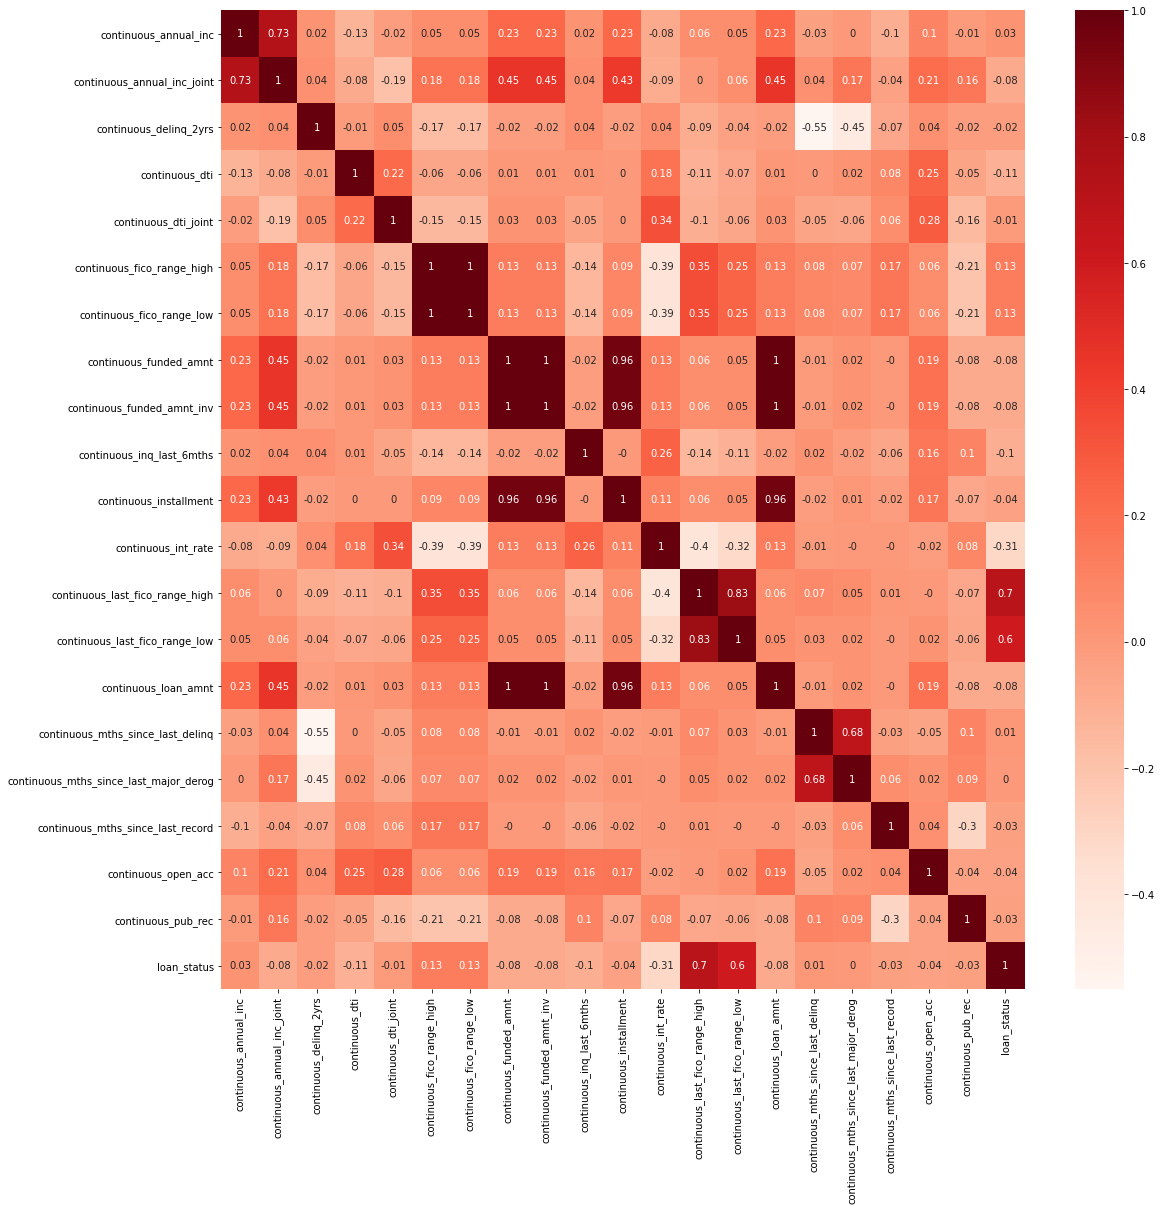

In [198]:
one_hot_cols = [col for col in data.columns.tolist() if '_one_hot' in col]

fea_train = train.copy()
fea_train = fea_train.drop(one_hot_cols, axis=1)

plt.figure(figsize=(18,18))
sns.heatmap(round(fea_train.corr(),2), cmap='Reds', annot=True)
plt.show()


## new feature

In [199]:
# !pip install category_encoders

In [200]:
# import category_encoders as ce

# encoder = ce.TargetEncoder(cols=['continuous_funded_amnt', 'continuous_int_rate'])

# # Get a new clean dataframe
train1=train.copy()
test1=test.copy()
# print(len(train1.columns))

# # Specify the columns to encode then fit and transform
# encoder = ce.BackwardDifferenceEncoder(cols=['continuous_installment', 'continuous_inq_last_6mths'])
# train_new1 = encoder.fit_transform(train1, verbose=1)
# test_new1 = encoder.fit_transform(test1, verbose=1)


# 从 Correlation Graph 看到 continuous_funded_amnt 和 continuous_inq_last_6mths 的相关性为 -0.02
# 提高变量直接的相关性，能否提高模型准确性？
# 构造衍生变量，continuous_funded_amnt/continuous_inq_last_6mths，还款金额除以最近6个月的申请次数，一定程度上反映近半年的消费的情况
train1=train.copy()
train1['current_trade_ratio'] = train1['continuous_funded_amnt'] / train1['continuous_inq_last_6mths']

test1=test.copy()
test1['current_trade_ratio'] = train1['continuous_funded_amnt'] / train1['continuous_inq_last_6mths']

In [201]:
train_pred_new1, test_pred_new1, acc_result_new1, models_new1 = fitter.train_k_fold(kfold, train1, test1, params = params)
train_pred_new1, test_pred_new1, acc_result_new1, models_new1

The minimum is attained in round 425
The minimum is attained in round 475
The minimum is attained in round 510
The minimum is attained in round 655
The minimum is attained in round 320


(array([0.57470598, 0.9861118 , 0.98838246, ..., 0.98725365, 0.99754199,
        0.99423654]),
 array([1.12317807, 1.19667718, 1.17909403, ..., 1.16806167, 1.19282615,
        1.19314591]),
 [0.0716,
  0.0806,
  0.08340000000000003,
  0.08340000000000003,
  0.08020000000000005],
  <lightgbm.basic.Booster at 0x7fd092c21f50>])

In [204]:
# 添加衍生变量后的错误率
accuracy_score_new1 = np.mean(acc_result_new1)
accuracy_score_new1

0.07984000000000002

In [205]:
# 添加衍生变量后，错误率降低程度
accuracy_score_base - accuracy_score_new1, (accuracy_score_base - accuracy_score_new1)/accuracy_score_base

(0.0003799999999999776, 0.004736973323360478)